# Import Packages

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Utility Functions

In [4]:
def plotSeries(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [5]:
def trend(time, slope=0):
    return slope * time


In [6]:
def seasonalPattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonalPattern(season_time)


In [8]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# The Synthetic DATA

In [9]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [11]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

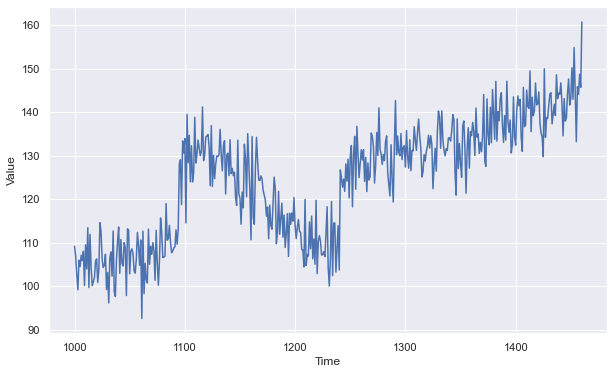

In [12]:
plt.figure(figsize=(10, 6))
plotSeries(time_valid, x_valid)

# Naive Training

In [13]:
def windowedDataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
dataset = windowedDataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [17]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


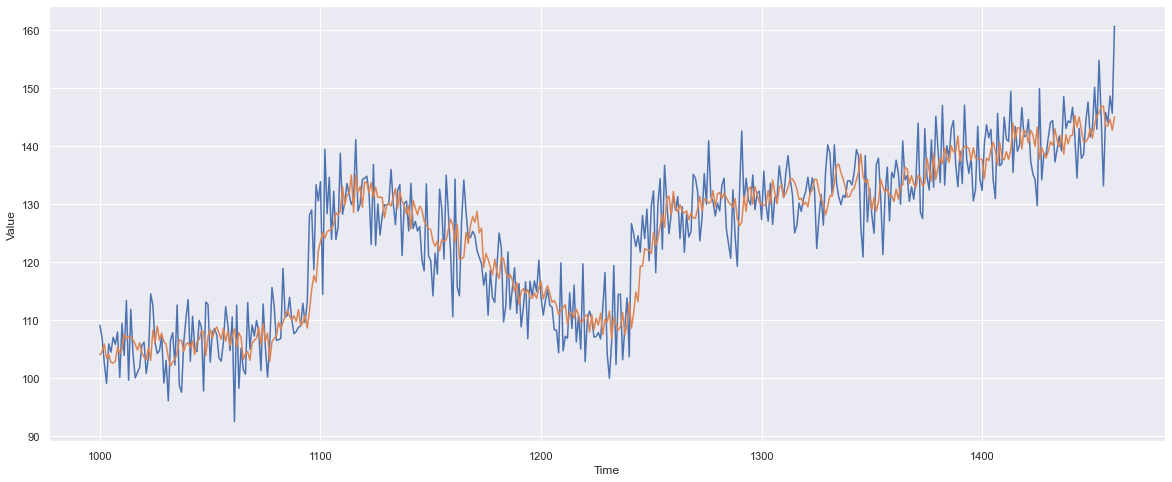

In [23]:
plt.figure(figsize=(20, 8))

plotSeries(time_valid, x_valid)
plotSeries(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.629062

# Optimizing LearningRate

In [20]:
modelLRS = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
modelLRS.compile(loss="mse", optimizer=optimizer)
history = modelLRS.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

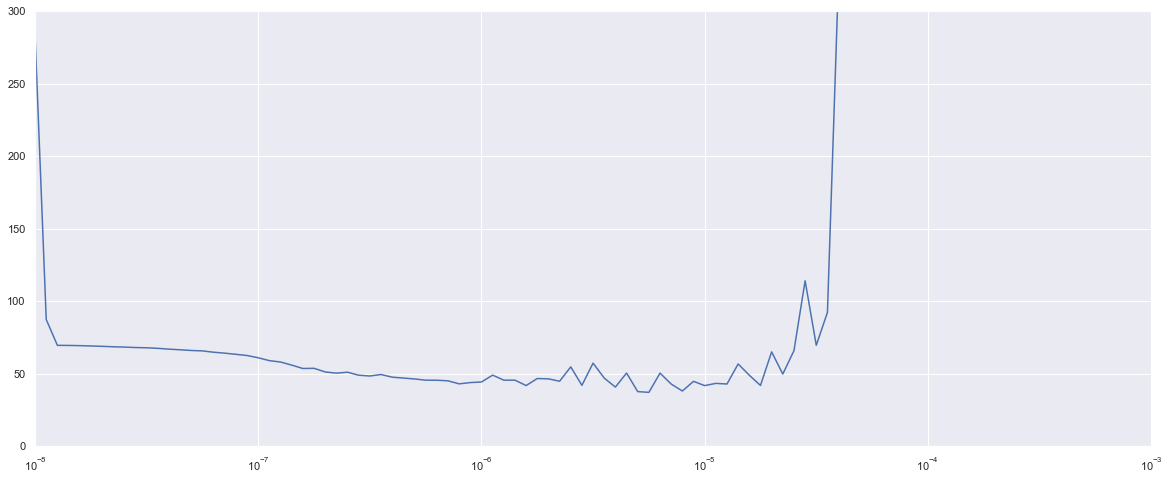

In [24]:
plt.figure(figsize=(20, 8))
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

# Revised Training

In [31]:
modelR = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
modelR.compile(loss="mse", optimizer=optimizer)
history = modelR.fit(dataset, epochs=1000, verbose=0)

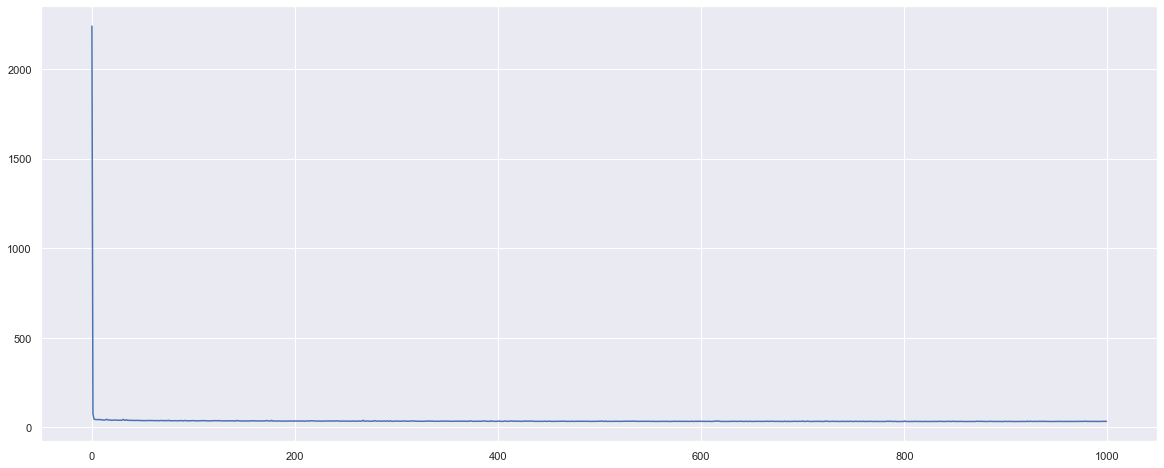

In [32]:
plt.figure(figsize=(20, 8))
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

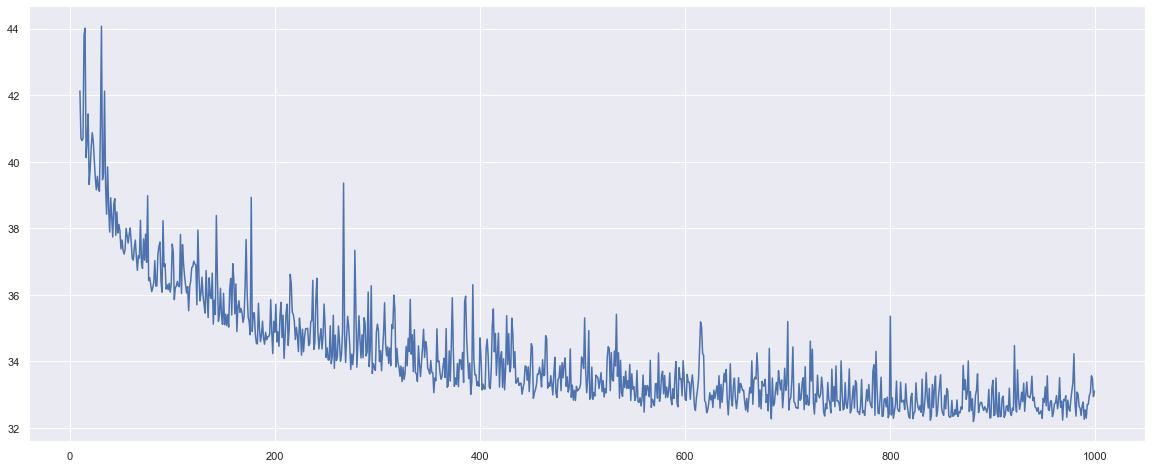

In [33]:

# Plot all but the first 10
plt.figure(figsize=(20, 8))
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
#print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()